# Theme : Deep Learning Models for Colorectal Cancer Detection and Classification Notebook
## Authors
- BELHADDAD mohamed islem (email: belhaddad.mohamed7@gmail.com)
- SAIM ouail (email: ouail.saim@gmail.com)

## Preamble
In this notebook, we built a deep learning model to classify images in the ["NCT-CRC-HE-100k"](https://zenodo.org/record/1214456) dataset, published by National Center for Tumor Diseases in Heidelberg, Germany, into <span style="color:#ff0077">9</span> different classes. We used a convolutional neural network architecture consisting of several convolutional and max pooling layers, followed by a dense layer with dropout and a softmax activation function for the output layer. We trained the model for <span style="color:#ff0077">10</span> epochs with a batch size of <span style="color:#ff0077">583</span> and used a validation set to monitor the training progress. We also used callbacks for checkpointing and reducing the learning rate on plateau. The model achieved a test accuracy of 98% on the ["NCT-CRC-HE-100k"](https://zenodo.org/record/1214456) dataset.


# Import Libraries

In [1]:
# Imports
import os, warnings, cv2
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import pandas as pd

from os import listdir
from os.path import isfile, join
from shutil import rmtree

from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1| Data Understanding

### 1.1| Load the directory 

In [2]:
main_path = '/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K'
sub_dir =os.listdir(main_path)

By creating a Pandas dataframe from our data, we can easily shuffle, partially remove, or manipulate it without worrying about the size of the image data.

### 1.2| Create The DataFrame

In [3]:
Data_df=pd.DataFrame({'ID': [], 'Class':[]})

for subdir in sub_dir:
    mypath = join(main_path,subdir)
    files=[f for f in listdir(mypath)]
    classes=[subdir for c in files]
    files_df = pd.DataFrame({'ID':files, 'Class':classes})
    Data_df = Data_df.append(files_df)

Data_df

/tmp/ipykernel_31/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_31/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_31/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_31/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_31/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = 

,ID,Class
0,MUC-GQLYEALK.tif,MUC
1,MUC-FYTGWFGD.tif,MUC
2,MUC-AVNDTFWS.tif,MUC
3,MUC-DQPFGFLS.tif,MUC
4,MUC-FNEDYLHG.tif,MUC
...,...,...
10441,STR-NQFCFNPH.tif,STR
10442,STR-KPWLGGCI.tif,STR
10443,STR-FFCLCFPE.tif,STR
10444,STR-HGPELQKY.tif,STR


### 1.3| Data Visualization
The problem can be better understood by visualizing the distribution of the data. In most cases, an imbalanced dataset cannot produce a quality model. However, in this case, the distribution does not seem to be a source of concern as shown below.

Furthermore, examining the patches within our data indicates that patches from different classes are easily distinguishable, suggesting that there should be no major issues in this regard.

In [4]:
# Distribution of the Classes
class_of_patch = Data_df.Class.value_counts()
print('the distribution of classes:\n{}'.format(class_of_patch[::-1]))

the distribution of classes:
NORM     8763
MUC      8896
ADI     10407
STR     10446
BACK    10566
DEB     11512
LYM     11557
MUS     13536
TUM     14317
Name: Class, dtype: int64


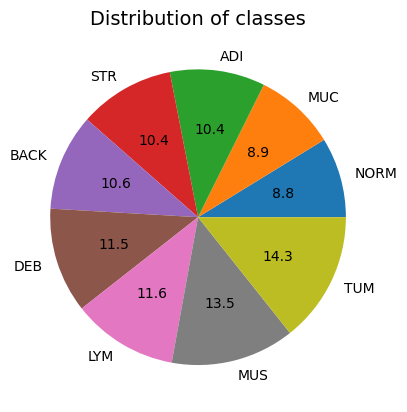

In [5]:
class_of_patch_labels = ['NORM','MUC','ADI','STR','BACK','DEB','LYM','MUS','TUM']
class_of_patch_values = class_of_patch[::-1]

plt.pie(class_of_patch_values, labels=class_of_patch_labels, startangle=0, autopct='%1.1f')
plt.title('Distribution of classes', fontsize=14)
plt.show()


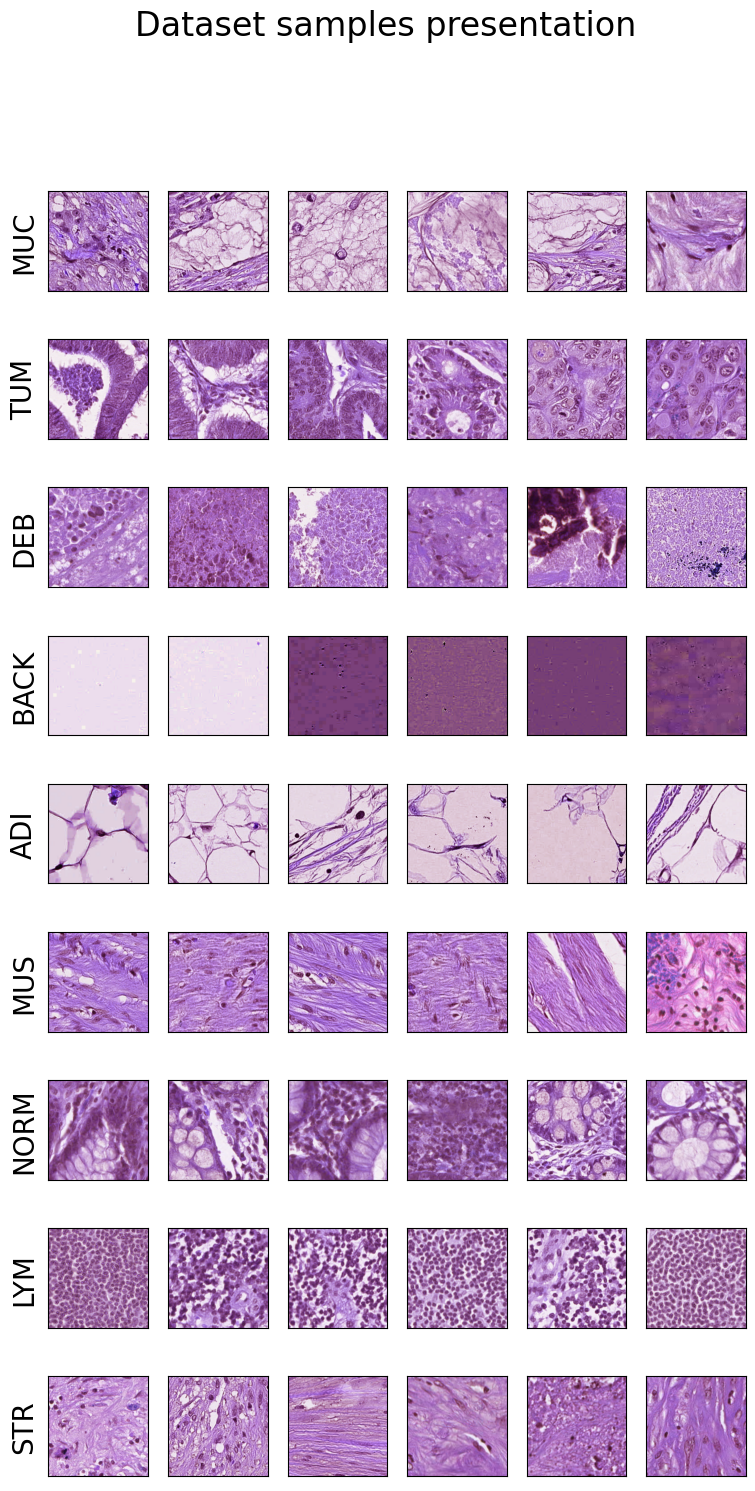

In [6]:
fig, axs = plt.subplots(9, 6, figsize=(9, 17))
fig.suptitle('Dataset samples presentation', size=24)

for i, cls in enumerate(sub_dir):
    samples = Data_df[Data_df['Class'] == cls].sample(6)
    for j, img_path in enumerate(samples['ID']):
        img = cv2.imread(join(main_path, cls, img_path))
        axs[i, j].imshow(img)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    axs[i, 0].set_ylabel(cls, size=20)

### 1.4| Spliting The Data to Training and Validation Sets
On the basis of our dataframe, now we can split our dataset for the use of training, validation and testing. Further, we can plot quantities of each set to check for any imbalance between same classes of each set. Altough it is not necessary, because this issue is considered in the used module from sklearn library.

In [7]:
# Split into train and test
train_df, test_df = train_test_split(Data_df, test_size=0.15, random_state=42, shuffle=True, stratify=Data_df['Class'])

# Split train set into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.176471, random_state=42, shuffle=True, stratify=train_df['Class'])

Class Distribution of Training Examples:
TUM     10021
MUS      9475
LYM      8090
DEB      8058
BACK     7396
STR      7312
ADI      7285
MUC      6228
NORM     6134
Name: Class, dtype: int64 

Class Distribution of Validation Examples:
TUM     2148
MUS     2031
LYM     1733
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1315
Name: Class, dtype: int64 

Class Distribution of Test Examples:
TUM     2148
MUS     2030
LYM     1734
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1314
Name: Class, dtype: int64 



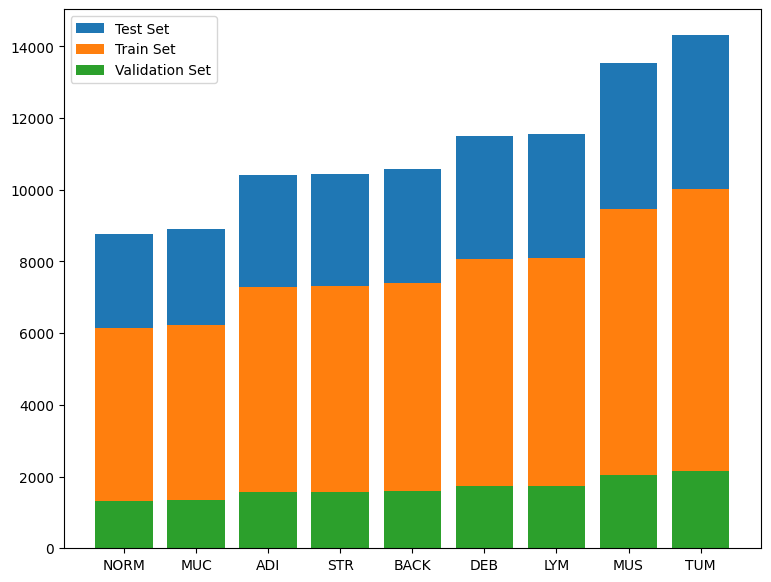

In [8]:
# Check the distribution of data in training and validation sets
train_val_test_data = [train_df, val_df, test_df]
data_names = ['Training', 'Validation', 'Test']

for i, data in enumerate(train_val_test_data):
    class_of_data_patch = data.Class.value_counts()
    print('Class Distribution of {} Examples:\n{}'.format(data_names[i], class_of_data_patch), '\n')
    
# Bar plot for checking the distribution
class_of_train_patch = train_df.Class.value_counts()
class_of_val_patch = val_df.Class.value_counts()
class_of_test_patch = test_df.Class.value_counts()

bar_fig, bar_axis = plt.subplots(figsize=(9,7))

sub_dir_list =  ['NORM', 'MUC', 'ADI', 'STR', 'BACK', 'DEB', 'LYM', 'MUS', 'TUM']

bar_axis.bar(sub_dir_list, class_of_patch[::-1], label='Test Set')
bar_axis.bar(sub_dir_list, class_of_train_patch[::-1], label='Train Set')
bar_axis.bar(sub_dir_list, class_of_val_patch[::-1], label='Validation Set')

bar_axis.legend()


### 1.4.1| Creating Folders for the Splited Data
For Convinience. it is better to write the splitted sets of data to seperated directories. In that way,we could simply call them from the directory into our generator.

In [9]:
# # remove the SplittedData folder
# import shutil

# # dir_path = '/kaggle/working/SplittedData'

# shutil.rmtree(dir_path)

In [10]:
main_dir = '/kaggle/working/SplittedData'
os.makedirs(main_dir, exist_ok=True)

train_dir = os.path.join(main_dir, 'Training')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(main_dir, 'Validation')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(main_dir, 'Test')
os.makedirs(test_dir, exist_ok=True)

for cls in sub_dir:
    train_sub_dir = os.path.join(train_dir, cls)
    os.makedirs(train_sub_dir, exist_ok=True)

    val_sub_dir = os.path.join(val_dir, cls)
    os.makedirs(val_sub_dir, exist_ok=True)

    test_sub_dir = os.path.join(test_dir, cls)
    os.makedirs(test_sub_dir, exist_ok=True)


### 1.4.2| Writing the splitted data in folders

In [11]:
from tqdm import tqdm
import shutil

Data_df.set_index('ID', inplace=True)

for img, label in tqdm(zip(train_df['ID'], train_df['Class']), desc='Copying train images'):
    source = join(main_path, label, img)
    dest = join(train_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(val_df['ID'], val_df['Class']), desc='Copying validation images'):
    source = join(main_path, label, img)
    dest = join(val_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(test_df['ID'], test_df['Class']), desc='Copying test images'):
    source = join(main_path, label, img)
    dest = join(test_dir, label)
    shutil.copy(source, dest)


Copying train images: 69999it [15:29, 75.30it/s]
Copying validation images: 15001it [03:28, 72.00it/s]
Copying test images: 15000it [03:33, 70.13it/s]


# 2| Data Augmentation
Data augmention recognised as a reliable technic to overcome flaws like overfitting and imblance. alongside, the "ImageDataGenerator" module, provides some tools that are helpful for feeding data to our model. Here, we only used horizontal and vertical flips generators on our data.

In [12]:
img_size = 224
img_channel=3
input_shape=(img_size,img_size,img_channel)
BATCH_size =128
learning_rate = 3E-4    # means 3x10^-4
train_step = (len(train_df)/BATCH_size)
val_step = (len(val_df)/BATCH_size)

datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, vertical_flip = True)

train_ds= datagen.flow_from_directory(train_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = True,
                                     seed = 101,
                                     interpolation = 'nearest',
                                     class_mode='categorical')
val_ds = datagen.flow_from_directory(val_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

test_ds = datagen.flow_from_directory(test_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

print(train_ds.class_indices)

Found 69999 images belonging to 9 classes.
Found 15001 images belonging to 9 classes.
Found 15000 images belonging to 9 classes.
{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}


# 3| Methodology 
ResNet50 architecture is already deployed in application module of keras API, so there is no need to build the model from scratch. We are using standard workflow recommended by [Keras](http://keras.io/guides/transfer_learning/), which is consists of two main steps__ weight-fetching and fine-tuning.

### 3.1| Callbacks

In [13]:
saved_model_path = 'modelinception.h5'
checkpoint = ModelCheckpoint(saved_model_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, 
                                   verbose=1, mode='max',min_delta=0.001, min_lr=0.0000001)

### 3.2| proposed architecture

#### 3.2.1| Weight Fetching (Feature Extarction):

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

<AxesSubplot: >

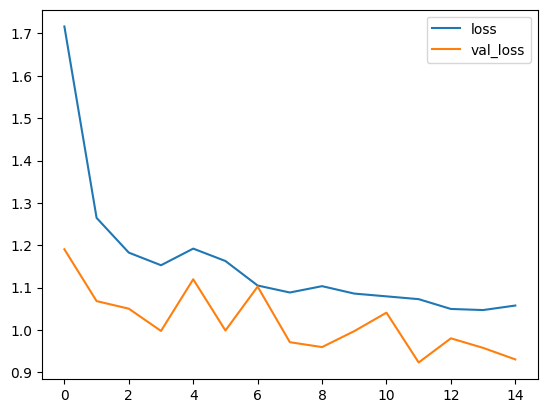

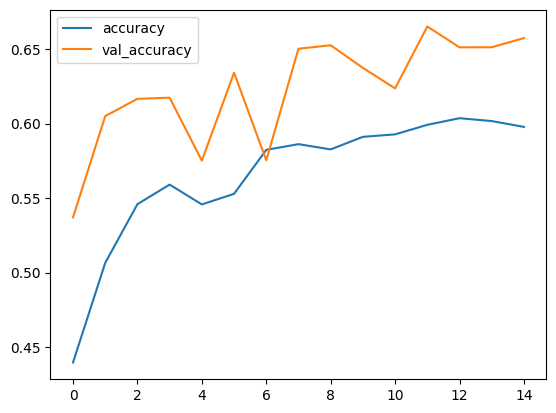

In [14]:
# Load the ResNet50 model with pre-trained weights
base_model = keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Add new layers to the model
model = keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation= 'softmax'))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(epsilon=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model.summary())

# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=train_step,
    shuffle=True,
    validation_data=val_ds,
    validation_steps=val_step,
    verbose=1,
    epochs=15,
    callbacks=[checkpoint]
)

# Visualize the training history
hist_df = pd.DataFrame(history.history)
hist_df.loc[:, ['loss', 'val_loss']].plot()
hist_df.loc[:, ['accuracy', 'val_accuracy']].plot()

#### 3.2.2 Fine Tuning:

In [15]:
model.load_weights('modelinception.h5')

base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, epsilon = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = model.fit(
    train_ds,
    steps_per_epoch= train_step,
    shuffle = True,
    validation_data = val_ds,
    validation_steps = val_step,
    verbose = 1,
    epochs = 10,
    callbacks=[checkpoint,reduce_lr])

# serialize model to JSON
model_json = model.to_json()
with open("CRC_detection_model.json", "w") as json_file:             
     json_file.write(model_json) 

# serialize weights to HDF5
model.save_weights("CRC_detection_model.h5")
print("Saved model to disk")

Epoch 1/10
547/546 [==============================] - ETA: 0s - loss: 0.7974 - accuracy: 0.7975
Epoch 1: val_loss did not improve from 0.92344
546/546 [==============================] - 467s 786ms/step - loss: 0.7974 - accuracy: 0.7975 - val_loss: 8.1244 - val_accuracy: 0.1123 - lr: 1.0000e-05
Epoch 2/10
547/546 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9510
Epoch 2: val_loss improved from 0.92344 to 0.45742, saving model to modelinception.h5
546/546 [==============================] - 427s 780ms/step - loss: 0.1519 - accuracy: 0.9510 - val_loss: 0.4574 - val_accuracy: 0.8570 - lr: 1.0000e-05
Epoch 3/10
547/546 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9720
Epoch 3: val_loss improved from 0.45742 to 0.06472, saving model to modelinception.h5
546/546 [==============================] - 431s 787ms/step - loss: 0.0897 - accuracy: 0.9720 - val_loss: 0.0647 - val_accuracy: 0.9791 - lr: 1.0000e-05
Epoch 4/10
547/546 [=================

# 4| Model Evaluation
learning curves does not show any sign of underfitting, nor overfitting. The trend is relatively flat and without any osciallation which display proper choice of batch size and learning rate.

15001/15001 [==============================] - 63s 4ms/step - loss: 0.0220 - accuracy: 0.9931
val_loss: 0.0220489464700222
val_acc: 0.9931337833404541


<AxesSubplot: >

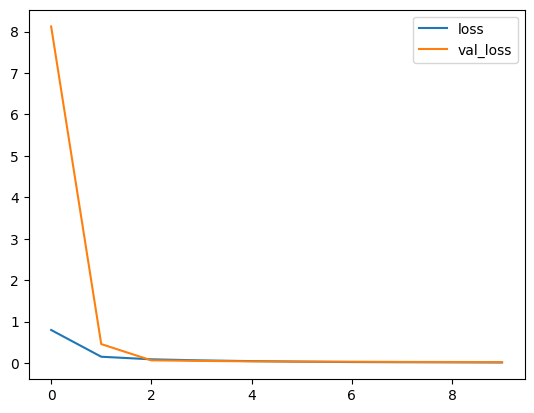

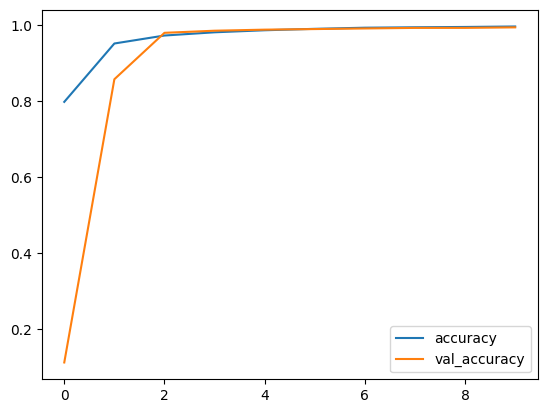

In [16]:
#Learning Curves

model.load_weights('modelinception.h5')

val_loss, val_acc = model.evaluate(val_ds, 
                        steps=len(val_df))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['accuracy','val_accuracy']].plot()

# 5| Prediction on Test set 
Since we have not a single set of metrics, because the validation metrics were for different epochs, we use our test set to acquire metrics based on which our model can be described. It can be interpreted from the report that model is enabled to distinguish between different classes, due to high precission, recall and f1 score. Also as a general metric, our accuracy is highly acceptable.

118/118 [==============================] - 66s 552ms/step
[[1557    0    0    0    1    3    0    0    0]
 [   0 1585    0    0    0    0    0    0    0]
 [   0    0 1707    0    1    4    0    7    8]
 [   0    0    0 1728    0    0    2    0    4]
 [   0    0    1    0 1320    1    4    4    4]
 [   2    0    1    0    0 2018    0    9    0]
 [   0    0    0    1    3    0 1298    0   12]
 [   0    0    8    0    4    9    1 1544    1]
 [   0    0    4    0    8    1    5    3 2127]]
              precision    recall  f1-score   support

         ADI       1.00      1.00      1.00      1561
        BACK       1.00      1.00      1.00      1585
         DEB       0.99      0.99      0.99      1727
         LYM       1.00      1.00      1.00      1734
         MUC       0.99      0.99      0.99      1334
         MUS       0.99      0.99      0.99      2030
        NORM       0.99      0.99      0.99      1314
         STR       0.99      0.99      0.99      1567
         TUM       0.9

<AxesSubplot: >

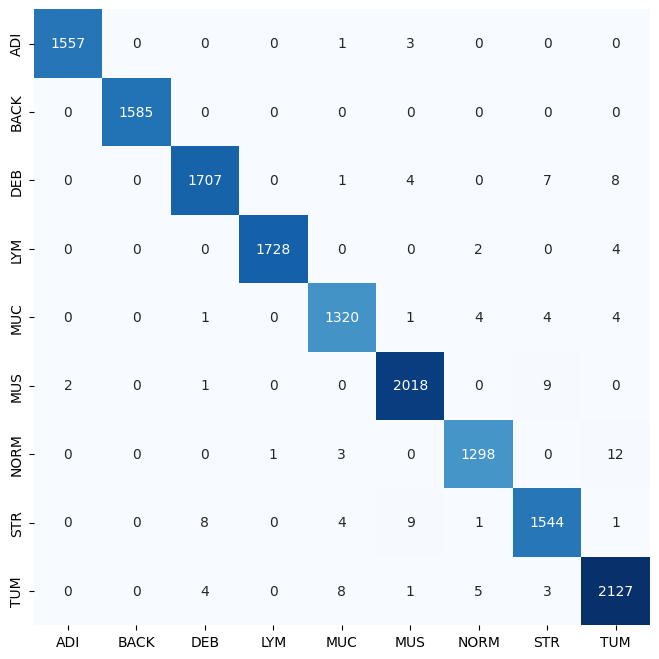

In [17]:
predictions = model.predict(test_ds, verbose=1)

y_true = test_ds.classes
y_pred = np.argmax(predictions,axis=1)

cm = confusion_matrix(y_true,y_pred)
print(cm)

labels = ['ADI','BACK', 'DEB','LYM','MUC','MUS','NORM','STR','TUM']
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot= True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels= labels)

# 6| Test Predictions on A Different Dataset
"CRC-VAL-HE-7k" is very analogous to our training data, in terms of labels, patch sizes and image qulities. However these data exteracted from whole different biopsy of different patients. Therefore, assessment of predictions on this dataset could be a reliable source of reliability evaluation on our classification engine.

Found 7180 images belonging to 9 classes.
225/225 [==============================] - 69s 306ms/step


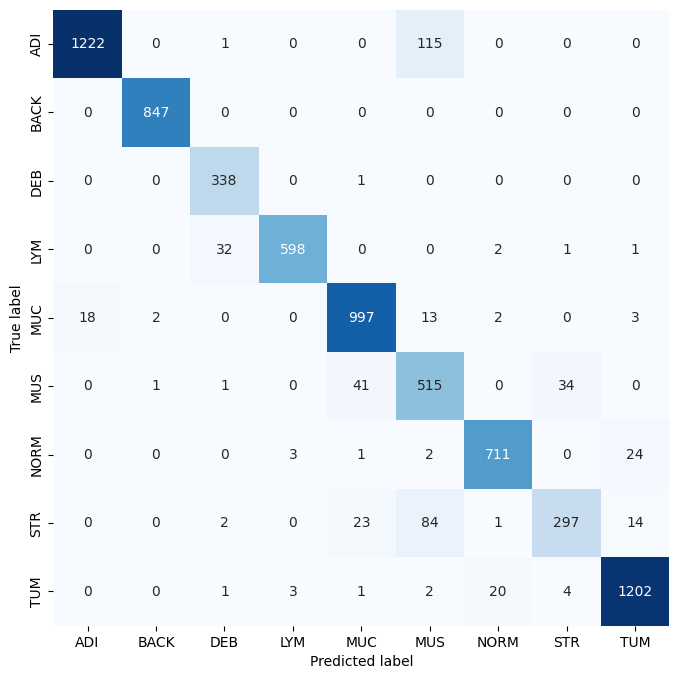

              precision    recall  f1-score   support

         ADI       0.99      0.91      0.95      1338
        BACK       1.00      1.00      1.00       847
         DEB       0.90      1.00      0.95       339
         LYM       0.99      0.94      0.97       634
         MUC       0.94      0.96      0.95      1035
         MUS       0.70      0.87      0.78       592
        NORM       0.97      0.96      0.96       741
         STR       0.88      0.71      0.78       421
         TUM       0.97      0.97      0.97      1233

    accuracy                           0.94      7180
   macro avg       0.93      0.93      0.92      7180
weighted avg       0.94      0.94      0.94      7180

15001/15001 [==============================] - 58s 4ms/step - loss: 0.0252 - accuracy: 0.9923
val_loss: 0.025156624615192413
val_acc: 0.9923333525657654


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load test set
test_dir = '../input/crc-val-he-7k/CRC-VAL-HE-7K'
test_set = datagen.flow_from_directory(test_dir, target_size= (224,224),batch_size = 32, 
                                       shuffle = False , class_mode='categorical' )

# Make predictions on test set
y_pred_non_decoded = model.predict(test_set, verbose=1)
y_pred = np.argmax(y_pred_non_decoded, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_set.classes, y_pred)

# Plot confusion matrix using seaborn
# sns.set(font_scale=1.2)
plt.figure(figsize=(10,8))
# sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
sns.heatmap(cm, annot= True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels= labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Print classification report, validation loss and accuracy
report = classification_report(test_set.classes, y_pred, target_names=labels)
print(report)

val_loss, val_acc = model.evaluate(test_ds, steps=len(val_df))
print('val_loss:', val_loss)
print('val_acc:', val_acc)


In [19]:
# test_dir = '../input/crc-val-he-7k/CRC-VAL-HE-7K'
# test_set = datagen.flow_from_directory(test_dir, target_size= (224,224),batch_size = 128, 
#                                        shuffle = False , class_mode='categorical' )

# y_pred_non_decoded = model.predict(test_set, verbose=1)
# y_pred = np.argmax(y_pred_non_decoded, axis=1)
# report = classification_report(test_set.classes, y_pred, target_names=labels)
# print(report)

# val_loss, val_acc = model.evaluate(test_ds, 
#                         steps=len(val_df))

# print('val_loss:', val_loss)
# print('val_acc:', val_acc)